# Hadamard test

## Overview

- **Type:** Gadget, subroutine
- **Approachability:** Easy
- **Prerequisites:** Phase kickback
- **Related topics:** Phase estimation, Amplitude estimation

The Hadamard test is a simple method of calculating the expectation value of a unitary operator. It uses phase kickback to encode the expectation value into the amplitudes of a single-qubit register. The Hadamard test is a gadget, or subroutine, rather than a full algorithm. It assumes you already know how to prepare the inputs and implement the controlled unitary.

## Description

Let's consider a unitary operator, $U$, acting on a pure state, $\vert \psi \rangle$. This action has expectation value $ \langle U \rangle = \langle \psi \vert U \vert \psi \rangle$. The Hadamard test measures the real and imaginary parts of $\langle U \rangle$ by inserting or removing an $S$ gate from the following circuit.

![Diagram of the Hadamard test circuit.](images/Hadamard_Basic.png)

### Real part

After applying the circuit without the $S$ gate, the resulting state is 

$$
\vert 0 \rangle \otimes \frac{\vert\psi \rangle + U \vert \psi \rangle}{2} + \vert 1 \rangle \otimes \frac{\vert\psi\rangle - U \vert\psi\rangle}{2}
$$

The probability $\Pr(0)$ of measuring zero in the first register is given by the Born rule.

$$
\begin{aligned}
\Pr(0) &= \frac14 (2 + \langle U \rangle + \langle U^\dagger \rangle) \\
&= \frac{1 + \mathrm{Re}\langle U \rangle}{2}
\end{aligned}
$$

Here, $\mathrm{Re}$ is the real part. We could simply repeat this experiment $N$ times to measure $\Pr(0)$, and therefore $\mathrm{Re} \langle U \rangle$, with accuracy $O(1/\sqrt{N})$. However, a better approach uses amplitude estimation rather than repeated measurements, which improves accuracy to an optimal $O(1/N)$ (the _Heisenberg limit_).  

### Imaginary part

With the $S$ gate inserted, the final state acquires a factor of $i$ in front of the $U$.

$$
\vert 0 \rangle \otimes \frac{\vert\psi \rangle + i U \vert \psi \rangle}{2} + \vert 1 \rangle \otimes \frac{\vert\psi\rangle - i U \vert\psi\rangle}{2}
$$

Now, the probability $\Pr(0)$ of measuring zero in the first register is given by

$$
\begin{aligned}
\Pr(0) &= \frac14 (2 + i\langle U \rangle -i \langle U^\dagger \rangle) \\
&= \frac{1 - \mathrm{Im}\langle U \rangle}{2}
\end{aligned}
$$

We can then use the same repeated measurements or amplitude estimation to estimate the imaginary part of the expectation value.

### For mixed states

If input state $\rho$ might not be a pure state, the expressions for the output probabilities are the same as for pure states with the understanding that 

$$
\langle U \rangle = \mathrm{Tr}(\rho U)
$$

However, the expressions for the states before measurement are more complicated. 

## Qiskit implementation

The following code defines a function to produce Hadamard test circuits.

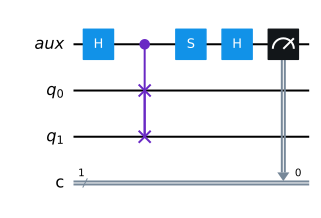

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library.standard_gates import SwapGate

def hadamard_circuit(U, add_s_gate=False, measure=True):
    """
    Args:
        U (Gate): Unitary gate to measure expectation value of
        add_s_gate (bool): Whether to measure real (False) or imaginary
            (True) parts of the expectation value
        measure (bool): Whether to measure the auxiliary qubit
    Returns:
        QuantumCircuit that implements the Hadamard test
    """
    # Initialize registers and circuit
    aux = QuantumRegister(1, 'aux')
    main = QuantumRegister(U.num_qubits, 'q')
    circuit = QuantumCircuit(aux, main)
    
    # Construct controlled-U gate
    cU = U.control(1)
    
    # Add gates to circuit
    circuit.h(aux)
    circuit.append(cU, aux[:] + main[:])
    if add_s_gate:
        circuit.s(aux)
    circuit.h(aux)
    
    # Add measurement if option specified
    if measure:
        creg = ClassicalRegister(1, 'c')
        circuit.add_register(creg)
        circuit.measure(aux, creg)
    
    return circuit

# Draw an example
circuit = hadamard_circuit(SwapGate(), add_s_gate=True, measure=True)
circuit.draw()

The following code uses the Hadamard test to estimate the expectation value of $\langle 00 | \text{SWAP} | 00 \rangle$.

In [2]:
from qiskit.primitives import Sampler

N = 10
U = SwapGate()

for part in ("Real", "Imaginary"):
    # Build circuit
    circuit = hadamard_circuit(
        U,
        add_s_gate=(False if part=="Real" else True),
        measure=True
    )

    # Run circuit and get qasi-probability distribution
    results = Sampler().run(
        circuit,
        shots=N
    ).result().quasi_dists[0]

    # Get qasi-probability of measuring 0 (default to 0 if not in distribution)
    p0 = results.get(0, 0)

    # Calculate estimate
    estimate = ((2 * p0) - 1) * (1 if part=="Real" else -1)
    print(f"{part} part of expectation value: {estimate}")

Real part of expectation value: 1.0
Imaginary part of expectation value: 0.4


## Applications

### Phase estimation

If the prepared state $\vert \psi \rangle$ is an eigenstate of $U$ with eigenvalue $e^{2\pi i \theta}$, then the expectation value will have the form $\langle U \rangle= e^{2\pi i \theta} = \cos(2\pi \theta) + i \sin(2\pi \theta)$.

Before measuring, the Hadamard circuit without phase gate yields

$$
\left(\frac{1 + e^{2\pi i \theta}}{2} \vert 0 \rangle + \frac{1 - e^{2\pi i \theta}}{2} \vert 1 \rangle\right) \otimes \vert \psi \rangle
$$

And therefore the probability of measuring zero is related to the phase $\theta$.

$$
\Pr(0) = \frac{1+\mathrm{Re}\langle U \rangle}{2} = \frac{1 + \cos 2\pi \theta}{2} = \cos^2(\pi \theta)
$$

Measuring this circuit determines $\theta$ up to two possible values ($\pm \theta$). The phase-gated Hadamard circuit resolves the ambiguity.

$$
\Pr(0) = \frac{1-\mathrm{Im}\langle U \rangle}{2} = \frac{1 - \sin 2\pi \theta}{2} = \sin^2(\pi \vert\theta- 1/4\vert)
$$

### SWAP test for pure-state fidelity

A specific case of the Hadamard test is the _SWAP test_, which calculates the fidelity of two states. Let $U = \mathrm{SWAP}$ and $|\psi\rangle = |\phi\rangle \otimes |\chi\rangle$. The Hadamard circuit takes the form 

![Circuit diagram of the SWAP test.](images/SWAP_pure.png)

Since $\mathrm{SWAP}$ is Hermitian, $\langle \mathrm{SWAP} \rangle$ is real and no $S$ gate is needed. The expectation value is given by

$$
\begin{aligned}
\langle\phi\vert \langle\chi\vert \,\mathrm{SWAP}\, \vert\phi\rangle \vert\chi\rangle &= \langle\phi\vert\chi\rangle \, \langle\chi\vert\phi\rangle \\
&= \vert \langle\chi\vert\phi\rangle\vert^2
\end{aligned}
$$

where $\vert \langle\chi\vert\phi\rangle\vert^2$ is the fidelity of $|\phi\rangle$ and $|\chi\rangle$.

### Measuring purity

The SWAP test does not compute fidelity for non pure states, but it can compute purity. We define the purity $w(\rho) \in [0,1]$ of a state $\rho$ by 

$$
w(\rho) = \mathrm{Tr}(\rho^2).
$$

Then, using the fact that

$$
\mathrm{Tr}(\rho^2) = \mathrm{Tr}(\,\mathrm{SWAP} \,\rho\otimes\rho)
$$

we can estimate $w(\rho)$ with a $\mathrm{SWAP}$ test with input state $\rho \otimes \rho$. 

## Generalizations

### Block encoding for non-unitary expectation values

When an operator $O$ can be block-encoded in a unitary $U$ through $(\langle B \vert \otimes I) U (\vert B \rangle \otimes I) = O$, then we have

$$
\mathrm{Tr}(O \rho) = \mathrm{Tr}(U \;\rho \otimes \vert B \rangle\langle B \vert).
$$

Therefore $\langle O \rangle$ can be estimated by a Hadamard test with $U$, provided $\vert B \rangle$ can be accurately and efficiently prepared on an auxiliary register.

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table